# Computing drawdown for SPY ETF

Drawdown is the maximum decline from peak to trough during a specific period before a new peak is reached. Every trading strategy experiences drawdowns. Computing it helps you compare the relative riskiness between assets or strategies.

Drawdown and max drawdown focus on capital preservation.

## Step 1: Get the data

In [1]:
# !pip install yfinance

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd

In [3]:
data = yf.download("SPY", start="2020-01-01", end = "2022-12-31")

[*********************100%***********************]  1 of 1 completed


In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,323.540009,324.890015,322.529999,324.869995,309.694946,59151200
2020-01-03,321.160004,323.640015,321.100006,322.410004,307.349792,77709700
2020-01-06,320.489990,323.730011,320.359985,323.640015,308.522400,55653900
2020-01-07,323.019989,323.540009,322.239990,322.730011,307.654907,40496400
2020-01-08,322.940002,325.779999,322.670013,324.450012,309.294556,68296000


In [5]:
data.shape, data.size

((756, 6), 4536)

In [6]:
# cheking if data contains any null values
data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
# Calulating returns (curr price - privious price)/previous price
returns = data["Adj Close"].pct_change()

In [8]:
returns

Date
2020-01-02         NaN
2020-01-03   -0.007572
2020-01-06    0.003815
2020-01-07   -0.002812
2020-01-08    0.005330
                ...   
2022-12-23    0.005752
2022-12-27   -0.003944
2022-12-28   -0.012428
2022-12-29    0.018000
2022-12-30   -0.002634
Name: Adj Close, Length: 756, dtype: float64

## Step 2: Create the drawdown function

When computing returns, the first value is turned into np.nan. I replace it with a 0.0 to compute cumulative returns. Then I create a cumulative return series which is the cumulative product of 1 plus the return. Next, I use NumPy’s accumulate function. Accumulate tracks the running maximum value which is perfect for keeping tabs on the peak return.

Finally, I compute the percentage difference between the cumulative and peak returns.

In [9]:
# EXTRA - cumprod
df = pd.Series([2, 3, 5, 2, 1, 52, 0])
df.cumprod()

0       2
1       6
2      30
3      60
4      60
5    3120
6       0
dtype: int64

In [12]:
def drawdown(returns, printMinimumDrop=False):
    """
    Determine the drawdown
    
    Parameters
    ----------
    returns : pd.Series of daily returns of an asset, noncumulative
    
    Returns
    ------
    drawdown : pd.Series
        
    """
    # replace the first nan value with 0.0
    returns.fillna(0.0, inplace = True)
    
    # Create cumulative returns - returns w.r.t staring price
    cumulative = (returns + 1).cumprod()
    
    # np.maximum.accumulate takes pd.Series of running max 
    # value and returns a pd.Series with each value being 
    # maximum value from start
    running_max = np.maximum.accumulate(cumulative)
    
    if printMinimumDrop:
        print(f'Maximum drop to { np.min(cumulative)*100:.2f}% on {cumulative[cumulative == np.min(cumulative)].index.values[0]}')
    
    # compute the change between the cumulative return
    # and the running maximum return
    return (cumulative - running_max) / running_max
    
    

Maximum drop to 69.03% on 2020-03-23T00:00:00.000000000


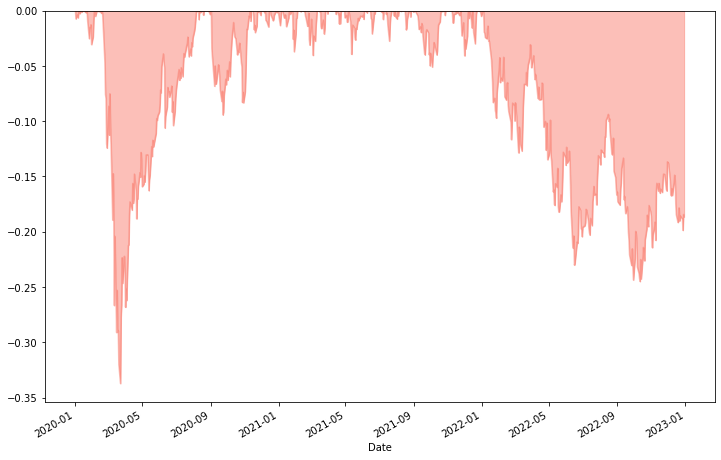

In [17]:
# Plot 
drawdown(returns, True).plot(kind="area", color="salmon", alpha = 0.5, figsize=(12, 8));

## Step 3: Create a max drawdown function

Using drawdown to compute a max drawdown chart.

The max drawdown differs from the drawdown by tracking the maximum drawdown of a 30-day rolling window of returns

In [14]:
def max_drawdown(returns):
    """
    Determine the maximum drawdown
    
    Parameters
    ----------
    returns : pd.Series of daily returns of an asset, noncumulative
    
    Returns
    ------
    max_drawdown : float
    
    """
    return np.min(drawdown(returns))

In [15]:
np.min(drawdown(returns))

-0.33717272929410486

max_drawdown applies the drawdown function to 30 days of returns and figures out the smallest (most negative) value that occures over those 30 days. Then it moves forward one day computes again and so on till the end of the series

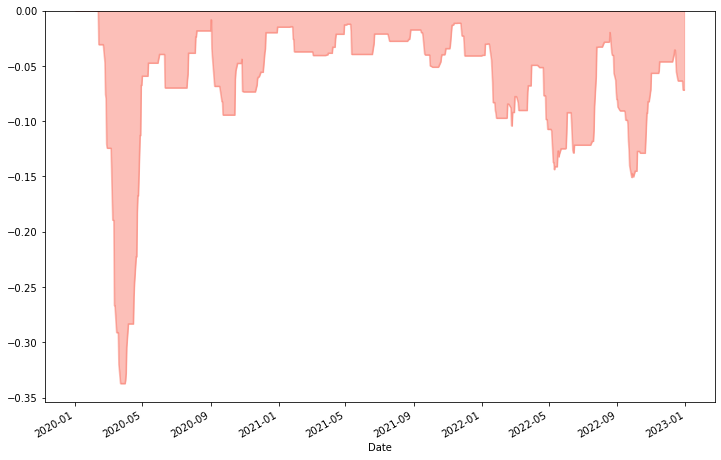

In [19]:
returns.rolling(30).apply(max_drawdown).plot(kind="area", 
                                             color="salmon",
                                            alpha=0.5,
                                            figsize=(12, 8));